<a href="https://colab.research.google.com/github/richiehodel/Botany2022_DLworkshop/blob/main/5_create_annotated_datasets/Botany_WorkShop_Train_Object_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training an Object Classifier**

In this notebook we will walk through the process of training an object classifier to identify rulers that commonly appear in digitized herbarium specimens.

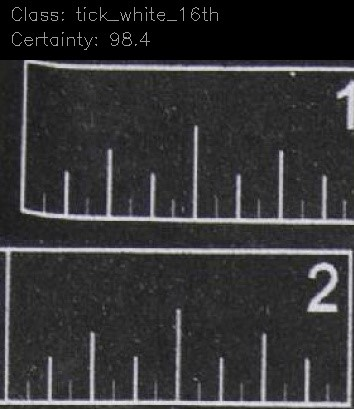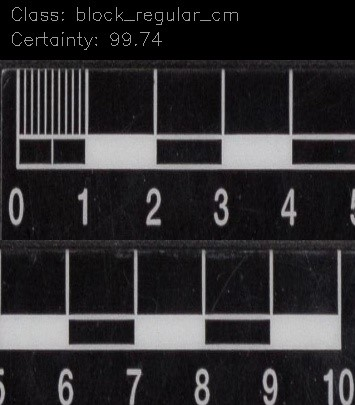

Object classifiers are a type of machine learning tool that is capable of analyzing an entire image and outputing a class prediction. 

While we are classifying rulers here, it is simple to swap-in your own dataset with minimal tweaks to this code. All you need to do is:

1.   Sort your images into folders, one folder for each class you wish to identify
> Note: All of your training images must be exactly 360 x 360 pixels. You can change this, but it involves changing the first layer of the Resnet model to accept different sizes. Normally for this kind of task, images of 360 x 360 pixels or 224 x 224 pixels work best. Larger images require *substantially* greater computational resources. 
2.   Provide your own class names file where each class name matches the folder name that contains the cooresponding images. Keep these in alphabetical order just to be safe.
3.   Ideally, sort your images into train/validation/test groups. The file structure will be the same, but instead of one data folder you would have 3 folders: 1) data_train 2) data_val 3) data_test. The images in each folder should not appear in the others; there should be no overlap. Try to find a way to have all classes represented in each of the 3 folders.
4.   Try to use a computer with a GPU. It's much much much faster
5.   If you want to train something for real, use a conda or python virtual environment locally on a PC with a CUDA capable GPU. 

# Activate GPU Runtime
**To use Colab with a GPU we need to change our runtime environment. At the top of this page look for the Runtime menu.**
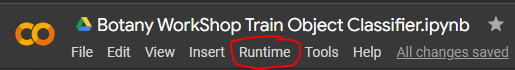

**Then we select "Change runtime type"**

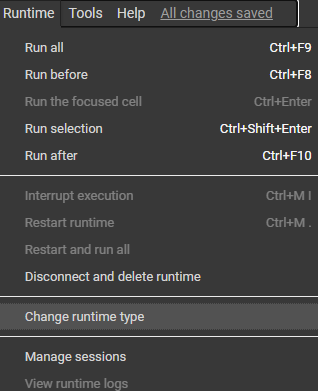

**And finally change Hardware Accelerator to GPU**

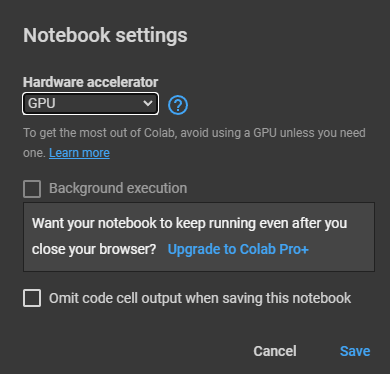

**Now our notebook has access to a Colab GPU.**

## Creating a python virtual environment
To create a virtual python environment on your local PC (Windows guide):



1.   Install Python 3.7.13
> This version no longer supports simple Windows installation. You can install a newer version if you do not want the hassle of installing an onlder version. Just note that mixing versions of python and versions of the required packages can get messy if you're not careful.
2.   Download files, set up file structure
> Download the files assosiated with this notebook and put them in a directory. Make sure the file structure looks the same as it does in this colab environment. Then open an Integrated Development Environment (IDE) or code editing software (I stongly recommend [Microsoft VS Code](https://code.visualstudio.com/download)) and use the terminal to move to your project directory that you created in step 1. 
3.   Install virtualenv
> python3 -m pip install --user virtualenv
4.   Create the virtual environment. It will inherit the default version of python. It's good to check this version after step 5. The 2nd 'venv' is the name of the folder that will contain the virtual environment, can be named differently.
> python3 -m venv venv
5.   Activate the venv
> ./venv/Scripts/activate
6.   Now any packages that we want to install using pip will be inside this venv. Start with installing -r requirements.txt
> pip install -r requirements.txt
7.   Then install pytorch
> pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
8.    If you have trouble with pytorch, you might need to make sure that the version of CUDA installed matches with the version of CUDA that pytorch wants

Please see this article for the inspriation behind some of this code:
https://www.pluralsight.com/guides/introduction-to-resnet
Thanks Gaurav Singhal for your well written article!

# **Prepare Python Environment**

Check python version. We need Python 3.7.13

In [ ]:
!python3 --version

We need to install the following packages:
*   matplotlib==3.2.2
*   matplotlib==3.2.2
*   opencv-python==4.5.5.64
*   numpy==1.21.6
*   torch==1.11.0+cpu torchvision==0.12.0+cpu torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cpu

Either install them individually or simply install the 'requirements.txt' file

In [ ]:
!wget -P downloads/ https://www.dropbox.com/s/uxjh5tbgk0ayfj1/requirements.zip
!unzip downloads/requirements.zip
!pip install -r requirements.txt
# To use with cpu ONLY
#!pip install torch==1.11.0+cpu torchvision==0.12.0+cpu torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cpu
# For gpu use
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Install packages individually

In [ ]:
# !pip install matplotlib==3.2.2
# !pip install opencv-python==4.5.5.64
# !pip install numpy==1.21.6
# !pip install torch==1.11.0+cpu torchvision==0.12.0+cpu torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cpu

Load required files


1.   data - training images sorted into folders by class
2.   test - images to test our trained model
3.   ruler_classes.txt - class names for the images in data
4.   model - folder contining resnet base, pretrained, and scripted models

In [ ]:
# Load 3 versions of training data
# !wget -P downloads/ https://www.dropbox.com/s/9ucg62mkmgzlwhm/data_large.zip
# !unzip downloads/data_large.zip

# !wget -P downloads/ https://www.dropbox.com/s/lekiirvtsbxwtwb/data_small.zip
# !unzip downloads/data_small.zip

!wget -P downloads/ https://www.dropbox.com/s/r1odj9nvundd9vs/data_tiny.zip
!unzip downloads/data_tiny.zip

# Load evaluation images
!wget -P downloads/ https://www.dropbox.com/s/fc437dnzj26wvmz/test.zip
!unzip downloads/test.zip

# Load ruler class names
!wget -P downloads/ https://www.dropbox.com/s/bg1cevcj0ixoplh/ruler_classes.zip
!unzip downloads/ruler_classes.zip

# Load a few pretrained machine learning models
# 'model' contains 4 trained models ==> 250MB
# !wget -P downloads/ https://www.dropbox.com/s/p74k0pgxs27n51s/model.zip
# !unzip downloads/model.zip

# 'model_best' contains one trained model ==> 50MB
!wget -P downloads/ https://www.dropbox.com/s/k9nlocqmxznwimi/model_best.zip
!unzip downloads/model_best.zip

If at any point you wish to start completely fresh, set doStartFresh = True

Clean the slate...?

In [ ]:
doStartFresh = False

import shutil
import os
# Delete 'sample_data'
try:
  shutil.rmtree('sample_data')
except:
  pass 

if doStartFresh:
  delete_these = ['downloads','model','model_best','results','test','data','data_small','data_tiny','sample_data']
  for obj in delete_these:
    try:
      shutil.rmtree(obj)
    except:
      pass 
  try:
    os.remove('ruler_classes.txt')
  except:
    pass 
  try:
    os.remove('requirements.txt')
  except:
    pass 
  print("Clean Slate")

# **Load Packages**

Import all packages

In [ ]:
import os
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2

# **Define Functions**

Define all required functions.

I wrote quite a few functions to help us predict the classes of the rulers.

I'm happy to discuss any of these helper functions after the workshop, but
we'll skip over them right now.

In [ ]:
def printClassLabels(label_names):
    with open(os.path.abspath(label_names)) as f:
        classes = [line.strip() for line in f.readlines()]
        ind = 0
        for cls in classes:
            ind += 1
            print(f'Class {ind}: {cls}')

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def validateDir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

def loadClassNames(labelNames):
    with open(os.path.abspath(labelNames)) as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

def createWhiteBG(img,squarifyRatio,h,w):
    w_plus = w
    imgBG = np.zeros([h,w_plus,3], dtype=np.uint8)
    imgBG[:] = 255
    imgBG[:img.shape[0],:img.shape[1],:] = img
    return imgBG

def createOverlayBG(img):
    imgBG = np.zeros([450,360,3], dtype=np.uint8)
    imgBG[:] = 0

    imgBG[90:img.shape[0]+90,:img.shape[1],:] = img
    return imgBG

def makeImgHor(img):
    # Make image horizontal
    h,w,c = img.shape
    if h > w:
        img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img

def stackImage(img,squarifyRatio,h,w_plus,showImg):
    wChunk = int(w_plus/squarifyRatio)
    hTotal = int(h*squarifyRatio)
    imgBG = np.zeros([hTotal,wChunk,3], dtype=np.uint8)
    imgBG[:] = 255

    wStart = 0
    wEnd = wChunk
    for i in range(1,squarifyRatio+1):
        wStartImg = (wChunk*i)-wChunk
        wEndImg =  wChunk*i
        
        hStart = (i*h)-h
        hEnd = i*h
        imgBG[hStart:hEnd,wStart:wEnd] = img[:,wStartImg:wEndImg]
    if showImg:
        cv2.imshow('Single Channel Window', imgBG)
        cv2.waitKey(0)
    return imgBG

def calcSquarifyRatio(img):
    doStack = False
    h,w,c = img.shape
    # Extend width so it's a multiple of h
    ratio = w/h
    ratio_plus = math.ceil(ratio)
    w_plus = ratio_plus*h

    ratio_go = w/h
    if ratio_go > 4:
        doStack = True

    squarifyRatio = 0
    if doStack:
        for i in range(1,ratio_plus):
            if ((i*h) < (w_plus/i)):
                continue
            else:
                squarifyRatio = i - 1
                break
        while (w % squarifyRatio) != 0:
            w += 1
    return doStack,squarifyRatio,w,h

def squarify(imgSquarify,showImg,makeSquare,sz):
    imgSquarify = makeImgHor(imgSquarify)
    doStack,squarifyRatio,w_plus,h = calcSquarifyRatio(imgSquarify)

    if doStack:
        imgBG = createWhiteBG(imgSquarify,squarifyRatio,h,w_plus)
        imgSquarify = stackImage(imgBG,squarifyRatio,h,w_plus,showImg)

    if makeSquare:
        dim = (sz, sz)
        imgSquarify = cv2.resize(imgSquarify, dim, interpolation = cv2.INTER_AREA)
    return imgSquarify

def preprocessImage(img,Transforms):
    img_sq = squarify(img,showImg=False,makeSquare=True,sz=360)
    img_t = Transforms(img_sq)
    img_tensor = torch.unsqueeze(img_t, 0)
    return img_tensor,img_sq

def detectRuler(net,classes,img,img_tensor,img_sq,img_name,dir_save,use_cuda):
    img_name = img_name.split('.')[0]

    if use_cuda:
        out = net(img_tensor.cuda())
    else:
        out = net(img_tensor)

    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    [(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]

    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    percentage = round(percentage[index[0]].item(),2)
    pred_class = classes[index[0]]

    imgBG = createOverlayBG(img_sq)
    addText = "True Class: "+str(img_name)
    addText1 = "Pred Class: "+str(pred_class)
    addText2 = "Certainty: "+str(percentage)
    imgOverlay = cv2.putText(img=imgBG, text=addText, org=(10, 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(155, 155, 155),thickness=1)
    imgOverlay = cv2.putText(img=imgBG, text=addText1, org=(10, 45), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(155, 155, 155),thickness=1)
    imgOverlay = cv2.putText(img=imgOverlay, text=addText2, org=(10, 70), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(155, 155, 155),thickness=1)
    cv2.imwrite(os.path.abspath(os.path.join(dir_save,'Prediction_'+img_name+'.jpg')),imgOverlay)

    print(f"{bcolors.BOLD}Image: {img_name}.jpg{bcolors.ENDC}")
    if (img_name.find('fail') != -1):
      print(f"{bcolors.BOLD}     True Class: {str(img_name.split('_')[0])}{bcolors.ENDC}")
      print(f"{bcolors.BOLD}     Pred Class: {pred_class}{bcolors.ENDC}")
      print(f"{bcolors.BOLD}     Certainty: {percentage}{bcolors.ENDC}")
    else:
      print(f"{bcolors.BOLD}     True Class: {str(img_name)}{bcolors.ENDC}")
      print(f"{bcolors.BOLD}     Pred Class: {pred_class}{bcolors.ENDC}")
      print(f"{bcolors.BOLD}     Certainty: {percentage}{bcolors.ENDC}")

    if img_name == pred_class:
      print(f"{bcolors.OKGREEN}     CORRECT!!!\n{bcolors.ENDC}")
    elif (img_name.find('fail') != -1):
      if img_name.split('_')[0] == pred_class:
        print(f"{bcolors.OKGREEN}     CORRECT!!!\n{bcolors.ENDC}")
      else:
        print(f"{bcolors.FAIL}     nope :(\n{bcolors.ENDC}")
    else:
      print(f"{bcolors.FAIL}     nope :(\n{bcolors.ENDC}")
    return pred_class,percentage

# **Setting Variables**

Provide directory locations


*   'data' - contains the training images
*   'results' - will contain the output images from our trained model in the "Evaluate Model" section of the notebook
*   'test' - contains 12 images for evaluation
*   'model' - directory containing base resnet18 architectures AND a model that I already trained on the ruler dataset
*   'ruler_classes.txt' - contains the class names 



Decide whether to use 1 of 3 training datasets:

1.   'data_large' - contains 10,600 training images
2.   'data_small' - contains 850 training images
3.   'data_tiny' - contains only 150 training images



In [ ]:
# Directory for our training images
dir_large = os.path.join(os.getcwd(),'data_large')

# Directory for our training images
dir_small = os.path.join(os.getcwd(),'data_small')

# Directory for our training images
dir_tiny = os.path.join(os.getcwd(),'data_tiny')

# Assign one of the data folder to be the training data
dir_train = dir_tiny

In [ ]:
# Directory to save our final predictions
dir_save = os.path.join(os.getcwd(),'results')
# This function will create dir_save if it does not exist
validateDir(dir_save)

# Set the directory of images to evaluate our moddel
dir_test = os.path.join(os.getcwd(),'test')

# Set the save location for our trained model
# dir_model = os.path.join(os.getcwd(),'model')
dir_model = os.path.join(os.getcwd(),'model_best')

#  Get the class labels of our dataset
dir_class_names = os.path.join(os.getcwd(),'ruler_classes.txt')
# Load the class names
classes = loadClassNames(dir_class_names)
# See the class label names
printClassLabels(dir_class_names)

Provide names for the models

In [ ]:
# Name our new model, ".pt" is the suffix for model files
# Each time you train, provide a different name to avoide overwriting 
new_resnet_model = 'model_scripted_resnet_Workshop_large.pt'

# The name of the model used in the "Evaluate Model" section
# Do not change the name below
trained_resnet_model = 'model_scripted_resnet_large.pt'

For the purposes of this workshop we will just use the training data
as the validation data.

But this in ***NOT BEST PRACTICE*** and will result in over fitting and other problems. 

Ideally, we want to split out groundtruth 
training data into 3 groups: 
1.   Training 70%   - for training the ML algorithm
2.   Validation 15% - correcting the ML algorithm during training
3.   Testing 15%    - unseen images testing "real-world" performance and the ML algorithm's ability to generalize

Note that the split does not have to be 70/15/15. 

In [ ]:
# Set the path to our training data
dir_train = dir_train
# Set the path to our validation data (for workshop purposes only, should NOT be the same as the training)
dir_val = dir_train

Here we will define deveral parameters for training our object classifier

In [ ]:
# Define the size of our input images.
# The squarify.py function will make sure that the imput images are 
# the correct size. 
imgSize = 360

# If your computer has a gpu, True
# Otherwise, False
use_cuda = True

# Set batch size - the number of images that the ML will 
# train with at a time. Go as big as you can without running out
# of system memory. If it crashes, decrease the size.
# Usually 72, 48, 32, 24, 12 
batch_size = 72

# Learning rate
learning_rate = 1e-3

# How many times the ML will train on the entire dataset. 
# n_epochs = 10+ to get a well-trained network
# Use n_epochs = 1 for testing 
n_epochs = 20 # Use 20 to fully train the network, fewer if short on time

# Set the number of classes
num_classes = 22

# Print progress every n batches
# Normally set this to 10 or 20, but since we're not training for long...
print_freq = 1

For each input image, we need to transform the image into a tensor format.

We are using a Pytorch class with one transformation --> transforms.ToTensor()

Other transformations can be stacked, such as image augmentation tools, which can be used to increase the size of training datasets and increase the variability of inputs that the ML algorithm is exposed to, usually increasing training accuracy and generalization power

In [ ]:
# define our transformation class
Transforms = transforms.Compose([transforms.ToTensor()])

Now we can load our training data using the pytorch datasets and DataLoader classes

In [ ]:
# Define the datasets using a pytorch class
train_dataset = datasets.ImageFolder(root= dir_train, transform=Transforms)
val_dataset = datasets.ImageFolder(root= dir_val, transform=Transforms)

# Load the datasets using a pytorch class
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Here we need to tell pytorch whether to use a gpu or cpu.

GPUs are much much faster, but right now we will use cpu

In [ ]:
# Pytorch will use the gpu if it's available, otherwise it will use cpu
# This may conflict with 'use_cuda' from above, so double check
if use_cuda:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
else:
    # If you want to use the cpu, you may use the line below
    device = torch.device('cpu')

Here, we will load a pretrained resnet18 model provided by pytorch.

For training on our dataset, we will load the pretrained resnet18 model.

Resnet models that use more layers (better accuracy) can also be used.

In [ ]:
net = models.resnet18(pretrained=True)
# If gpu and cuda are available, then the net is sent to the gpu
# If this line causes trouble comment it out
try:
  if use_cuda:
    net = net.cuda() if device else net
except:
  pass
# Visualize the layers in the ML network
net

Now we need to alter the default parameters of the resnet18 architecture.

We can define our loss function, optimizer, and change the fully connected layer (the layer that determines the final class prediction).

In [ ]:
# Define the desired loss and optimzer funtions
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

# Set the number of feature to be the number of classes
# By default resnet will try to detect 1,000 classes
number_of_features = net.fc.in_features
net.fc = nn.Linear(number_of_features, num_classes)
net.fc = net.fc.cuda() if use_cuda else net.fc

Our last step before training is to define some lists to hold training information

In [ ]:
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)

# **Training the Model**

**Expected Training Times**

Consumer GPU 8GB VRAM:

*   data_tiny - 20 epochs - 30 seconds
*   data_small - 20 epochs - 3 minutes
*   data_large - 20 epochs - 20 minutes

CPU:

*   data_tiny - 20 epochs - 5 minutes
*   data_small - 20 epochs - too long
*   data_large - 20 epochs - way too long

GPU - Colab
*   data_tiny - 20 epochs - 1 minute
*   data_small - 20 epochs - 6 minutes
*   data_large - 20 epochs - 70 minutes

CPU - Colab:

*   data_tiny - 20 epochs - 40 minutes, yikes!
*   data_small - 20 epochs - too long
*   data_large - 20 epochs - way too long

In [ ]:
# It's unlikely that the model will complete training on a cpu in our short timeframe
# To train, set doTrain = True
doTrain = True

# We can load a model that I pretrained on the ruler dataset
# and 
doEvaluate = True

In [ ]:
if doTrain:
    start = time.time()
    # For loop for each epoch (each loop will process the entire dataset)
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        print(f'\n')
        print(f"{bcolors.OKCYAN}Epoch {epoch}\n{bcolors.ENDC}")

        # Each batch contains a subset of the entire traiing dataset
        # The number of batches is determined by the size of the trianing
        # dataset divided by the batch size
        for batch_idx, (data_, target_) in enumerate(train_dataloader):
            # Sending the images to the cpu or gpu
            data_, target_ = data_.to(device), target_.to(device)
            optimizer.zero_grad()
            
            # Running the batch throught the ML algorithm
            outputs = net(data_)
            loss = criterion(outputs, target_)
            loss.backward()
            optimizer.step()

            # Calculate the training trajectory of for this batch
            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==target_).item()
            total += target_.size(0)

            # Print progress
            if (batch_idx) % print_freq == 0:
                print(f"{bcolors.BOLD}     Epoch [{epoch}/{n_epochs}], Step [{batch_idx}/{total_step}], Loss: {loss.item():.4f}{bcolors.ENDC}")
        
        # At the end of the batches we record our progress
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)

        print(f'\n')
        print(f"{bcolors.BOLD}     Epoch {str(epoch)} Summary:{bcolors.ENDC}")
        print(f"{bcolors.BOLD}     Training Loss: {np.mean(train_loss):.4f}, Training Accuracy: {(100 * correct/total):.4f}{bcolors.ENDC}")

        batch_loss = 0
        total_t=0
        correct_t=0

        # This is the validation component
        # Images that were not involved in the training process are used to determine
        # whether the network accuracy improved. If yes, we save the network progress and procede
        with torch.no_grad():
            net.eval()
            for data_t, target_t in (val_dataloader):
                data_t, target_t = data_t.to(device), target_t.to(device)
                outputs_t = net(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _,pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t/total_t)
            val_loss.append(batch_loss/len(val_dataloader))
            network_learned = batch_loss < valid_loss_min

            print(f"{bcolors.OKBLUE}     Validation loss: {np.mean(val_loss):.4f}, Validation Accuracy: {(100 * correct_t/total_t):.4f}\n{bcolors.ENDC}")

            # Save the network progress if it has improved
            if network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), os.path.join(dir_model,'resnet_progress.pt'))

                print(f"{bcolors.OKGREEN}     Improvement has been detected. Saving this model{bcolors.ENDC}")

        # This is critical. net.train() makes sure that the dropout layers, batch normalization layers,
        # etc. continue to be modifiable as training procedes. When weights in these layers change, the
        # network will either get better at the classification task or get worse. Once these
        # layers are frozen [ by calling net.eval() ] the weights will not change, allowing us to use the 
        # network to make predicions.
        net.train()

    end = time.time()
    print(f"{bcolors.OKGREEN}Training is complete! :){bcolors.ENDC}")
    print(f"{bcolors.OKGREEN}     Elapsed time: {end - start}\n{bcolors.ENDC}")


    # Now we need to save our trained machine learning network
    # In pytorch there are two ways to save the network:
    #      1. We can wave the weights. This is helpful if you want to retrain the network later
    #      2. We can save a scripted model. This allows us to quickly load our trained model and immediately use it to make predictions
    # We will use option 2 
    model_scripted = torch.jit.script(net) # Export to TorchScript
    model_scripted.save(os.path.join(dir_model,new_resnet_model)) # Save

    print(f"{bcolors.OKGREEN}Model Saved: {os.path.join(dir_model,new_resnet_model)}\n{bcolors.ENDC}")


# Evaluate Model

In [ ]:
# Use a fully trained model (trained prior to the workshop)
trained_resnet_model = 'model_scripted_resnet_large.pt'
selected_model = trained_resnet_model

# Use a model trained during the workshop, uncomment the line below.
#selected_model = new_resnet_model

# For Colab, we need to load the model (which I trained on a gpu) with the cpu 
# If you want to use a gpu in colab, rerun notebook with use_cuda = True
if use_cuda:
    device = torch.device('cuda')
    map="cuda:0"
else:
    device = torch.device('cpu')
    map = device

if doEvaluate:
    # Load our class names
    classes = loadClassNames(dir_class_names)
    # Get the file names of the images we want to process
    img_list = os.listdir(dir_test)

    # Load our trained object classifier network
    net = torch.jit.load(os.path.join(dir_model,selected_model),map_location=map)
    if use_cuda:
      net.to(device)
    # Set the network to evaluate mode
    # This freezes layers that would otherwise change 
    net.eval()

    # We will iterate through our test directory of images 
    for img_name in img_list:
        # Load the image
        img = cv2.imread(os.path.join(dir_test,img_name))
        # Preprocess the image, create a tensor image to imput into the network
        img_tensor,img_sq = preprocessImage(img,Transforms)
        # Detect the ruler class, save the output overlay image to dir_save
        pred_class,percentage = detectRuler(net,classes,img,img_tensor,img_sq,img_name,dir_save,use_cuda)